In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.manifold import TSNE


from XDCCA.algorithms.clustering import kmeans_clustering_acc, spectral_clustering_acc
from XDCCA.algorithms.losses_metrics import MetricDict, MovingMetric
from XDCCA.data.biosignal_table import BiosignalTableData
from XDCCA.experiments.biosignal import BiosignalDeepCCAExperiment

distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


In [3]:
dataprovider = BiosignalTableData.generate(
    window_length = 10,
    classes=['Relax1', 'PhysicalStress'],
    eval_subjects = ['Subject17', 'Subject18', 'Subject19', 'Subject20'],
)

2024-02-01 13:05:44.920933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
def cluster_dimesions(architect, dims):
    data_for_acc = dataprovider.eval_data

    outputs_met, labels_met = MetricDict(), MetricDict()
    for data in data_for_acc:
        outputs_met.update(architect(inputs=data, training=False))
        labels_met.update(dict(labels=data["labels"].numpy()))
    
    netw_output = outputs_met.output()
    labels = labels_met.output()["labels"]

    if len(dims) == 1:
        latent_repr_0 = netw_output["cca_view_0"][:,dims[0]][:,None]
        latent_repr_1 = netw_output["cca_view_1"][:,dims[0]][:,None]
    elif len(dims) == 2:
        latent_repr_0 = netw_output["cca_view_0"][:,dims[0]:dims[1]]
        latent_repr_1 = netw_output["cca_view_1"][:,dims[0]:dims[1]]
    
    clustering_0 = kmeans_clustering_acc(data_points=latent_repr_0, labels=labels, num_classes=dataprovider.num_classes)
    clustering_1 = kmeans_clustering_acc(data_points=latent_repr_1, labels=labels, num_classes=dataprovider.num_classes)
    
    return clustering_0, clustering_1, np.mean([clustering_0, clustering_1])

In [5]:
exp = BiosignalDeepCCAExperiment(
    log_dir='',
    encoder_config_v1=[(512, 'sigmoid'), (3, None)],
    encoder_config_v2=[(512, 'sigmoid'), (3, None)],
    dataprovider=dataprovider,
    shared_dim=3,
    lambda_rad=0,
    topk=10,
    max_perc=1,
    lambda_l1=0,
    lambda_l2=1e-3,
    cca_reg=1e-4,
    eval_epochs=10,
    val_default_value=0.0,
    convergence_threshold=0.000,
)

exp.train_multiple_epochs(3000)

exp.load_weights_from_log('avg')

view0_eval_acc = exp.compute_clustering_accuracy('view0', 'eval')
view1_eval_acc = exp.compute_clustering_accuracy('view1', 'eval')
eval_acc = np.mean([view0_eval_acc, view1_eval_acc])
print(view0_eval_acc)
print(view1_eval_acc)
print(eval_acc)
print('-----')

view0_acc, view1_acc, mean_acc = cluster_dimesions(exp.architecture, dims=[0,1])
print(view0_acc)
print(view1_acc)
print('-----')

view0_acc, view1_acc, mean_acc = cluster_dimesions(exp.architecture, dims=[1,2])
print(view0_acc)
print(view1_acc)
print('-----')

view0_acc, view1_acc, mean_acc = cluster_dimesions(exp.architecture, dims=[2,3])
print(view0_acc)
print(view1_acc)
print('-----')

Epochs:   0%|          | 0/3000 [00:00<?, ?it/s]

0.757085020242915
0.8340080971659919
0.7955465587044535
-----
0.7449392712550608
0.8704453441295547
-----
0.6153846153846154
0.5182186234817814
-----
0.6437246963562753
0.5465587044534413
-----


In [6]:
from complexity_regularized_dcca.algorithms.losses_metrics import MetricDict
from complexity_regularized_dcca.algorithms.clustering import kmeans_clustering_acc

In [7]:
for i, d in enumerate(dataprovider.eval_data):
    pass

netw_output = exp.architecture(d)

labels = d['labels'].numpy().tolist()

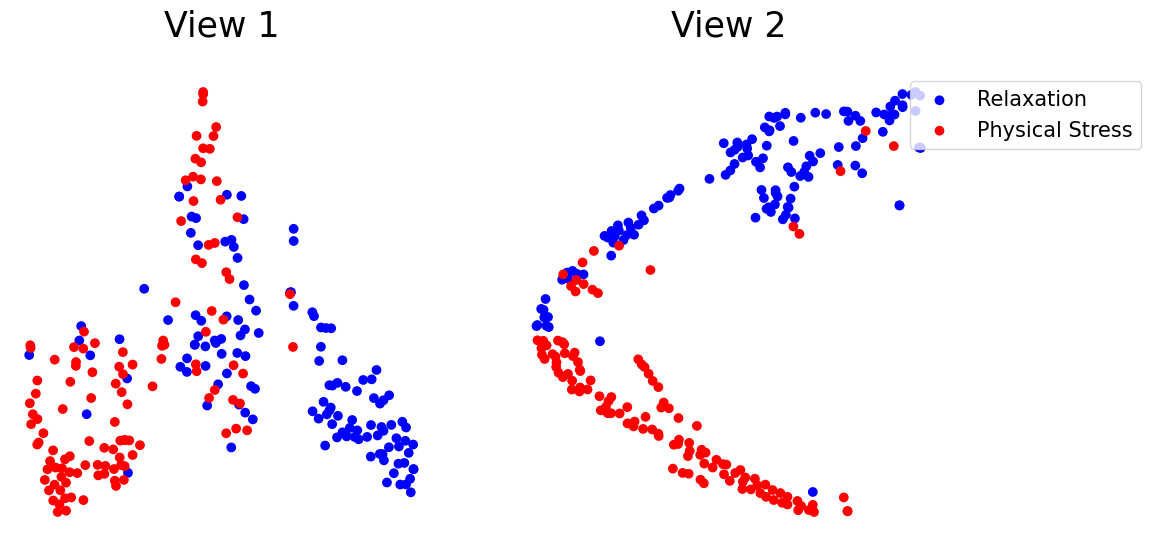

In [8]:
cca_view_0_tsne = TSNE(random_state=33).fit_transform(netw_output['cca_view_0'])
cca_view_1_tsne = TSNE(random_state=33).fit_transform(netw_output['cca_view_1'])

fig, axs = plt.subplots(1,2,figsize=(12,6))

colors = ['blue', 'red']

for label in np.unique(labels):
    i = np.where(labels == label)
    num_samples = cca_view_1_tsne[i,0].shape[1]
    color = colors[label]
    str_label = 'Relaxation' if label == 0 else 'Physical Stress'
    
    axs[0].scatter(cca_view_0_tsne[i,0], cca_view_0_tsne[i,1], c=[color]*num_samples);
    axs[1].scatter(cca_view_1_tsne[i,0], cca_view_1_tsne[i,1], c=[color]*num_samples, label=str_label)

axs[0].set_title('View 1', fontsize=25, pad=25)
axs[1].set_title('View 2', fontsize=25, pad=25)

axs[1].legend(loc='upper right', prop=dict(size=15), bbox_to_anchor=(1.5, 1.0))

axs[0].axis('off');
axs[1].axis('off');


In [9]:
fig.savefig('biosignal_cluster.png', bbox_inches='tight')

## SHAP

In [11]:
# Prepare data
for inp_data in dataprovider.eval_data:
    v0_data = inp_data['nn_input_0']
    v1_data = inp_data['nn_input_1']

eval_data_v0 = v0_data
eval_data_v1 = v1_data
eval_labels = inp_data['labels']

## Explainer

In [12]:
# Create input layer
new_input = tf.keras.layers.Input(shape=(4))

# Flatten and transform features via CCA matrix
view0_output = exp.architecture.encoder_v0(new_input)
view0_flattened_output = tf.keras.layers.Flatten()(view0_output)
view0_flattened_output_bars = tf.subtract(view0_flattened_output, exp.architecture.mean_v0)
view0_cca_feature = tf.transpose(exp.architecture.B1@tf.transpose(view0_flattened_output_bars))

# Create model to interpret
view0_model = tf.keras.Model(new_input, view0_cca_feature)

explainer_v0 = shap.DeepExplainer(
    view0_model,
    tf.identity(eval_data_v0).numpy()
)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [13]:
# Create input layer
new_input = tf.keras.layers.Input(shape=(7))

# Flatten and transform features via CCA matrix
view1_output = exp.architecture.encoder_v1(new_input)
view1_flattened_output = tf.keras.layers.Flatten()(view1_output)
view1_flattened_output_bars = tf.subtract(view1_flattened_output, exp.architecture.mean_v1)
view1_cca_feature = tf.transpose(exp.architecture.B2@tf.transpose(view1_flattened_output_bars))

# Create model to interpret
view1_model = tf.keras.Model(new_input, view1_cca_feature)

explainer_v1 = shap.DeepExplainer(
    view1_model,
    tf.identity(eval_data_v1).numpy()
)

## SHAP values

In [14]:
def compute_str_features_and_shap(view_idx, feature_idx, bins=4):
    if view_idx == 0:
        input_data = eval_data_v0.numpy()
        shap_values = explainer_v0.shap_values(input_data)
        modalities = dataprovider.view1_modalities
    elif view_idx == 1:
        input_data = eval_data_v1.numpy()
        shap_values = explainer_v1.shap_values(input_data)
        modalities = dataprovider.view2_modalities
        
    table_features_df = pd.DataFrame(data=input_data, columns=modalities)
    shap_features_df = pd.DataFrame(data=shap_values[feature_idx], columns=modalities)
    
    # Put into bins
    table_features_binned_df = table_features_df.copy()
    for column in table_features_binned_df.columns:
        table_features_binned_df[column] = pd.qcut(table_features_binned_df[column], q=3, duplicates='drop')
        
    # Create feature strings
    table_features_str_df = table_features_df.copy().astype(str)
    for ind in table_features_binned_df.index:
        for col in table_features_binned_df.columns:
            val = table_features_binned_df[col][ind]
            if type(val) == pd.Interval:
                name = f'{val.left:.2f}<{col}<={val.right:.2f}'
            elif type(val) == np.bool_:
                name = f'{col}_{val}'
            else:
                raise ValueError

            table_features_str_df.loc[ind, col] = name
            
    return table_features_str_df, shap_features_df

## Compute rules

In [15]:
pos_label = '1'
neg_label = '0'

def compute_rules(str_features_table_df, shap_features_df, shap_threshold=0.01, min_support=0.15, confidence_threshold=0.6):
    pos_features_list = []
    neg_features_list = []    

    for (row_idx, table_row), (_, shap_row) in zip(str_features_table_df.iterrows(), shap_features_df.iterrows()):
        table_idx_features = table_row.copy()
        shap_idx_features = shap_row.copy()
        shap_idx_features[table_idx_features.eq(0.0)] *= -1

        pos_features = set(
            [
                feature[1] for feature in table_idx_features[shap_idx_features>shap_threshold].items()
            ]
        )
        pos_features.add(pos_label)

        neg_features = set(
            [
                feature[1] for feature in table_idx_features[shap_idx_features<-shap_threshold].items()
            ]
        )
        neg_features.add(neg_label)

        pos_features_list.append(pos_features)
        neg_features_list.append(neg_features)

    itemset = set()
    itemset.add(pos_label)
    itemset.add(neg_label)

    for pos_features in pos_features_list:
        itemset = itemset.union(pos_features)

    for neg_features in neg_features_list:
        itemset = itemset.union(neg_features)

    encoded_vals = []

    def encode_vals(itemset, rowset):
        labels = {}

        uncommons = list(itemset - rowset)
        commons = list(itemset.intersection(rowset))

        for uc in uncommons:
            labels[uc] = bool(0)
        for com in commons:
            labels[com] = bool(1)

        encoded_vals.append(labels)

    for pos_features in pos_features_list:
        encode_vals(itemset, pos_features)

    for neg_features in neg_features_list:
        encode_vals(itemset, neg_features)

    ohe_df = pd.DataFrame(encoded_vals)
    
    freq_items = apriori(ohe_df, min_support=min_support, use_colnames=True, max_len=3)
    #print("Num. items: "+str(len(freq_items)))
    all_rules = association_rules(freq_items, metric="confidence", min_threshold=confidence_threshold, support_only=False)
    #print("Num. rules: "+str(len(all_rules)))
    
    return all_rules

## Interpret views

In [16]:
def compare_views(feature_idx, bins, shap_thr_v0=.001, shap_thr_v1=.001):
    table_df_v0, shap_df_v0 = compute_str_features_and_shap(view_idx=0, feature_idx=feature_idx, bins=3)
    table_df_v1, shap_df_v1 = compute_str_features_and_shap(view_idx=1, feature_idx=feature_idx, bins=3)
    all_rules_v0 = compute_rules(table_df_v0, shap_df_v0, shap_threshold=shap_thr_v0, confidence_threshold=1)
    all_rules_v1 = compute_rules(table_df_v1, shap_df_v1, shap_threshold=shap_thr_v1, confidence_threshold=1)
    
    # Sort for positive and negative
    pos_v0 = all_rules_v0[all_rules_v0['consequents'] == {pos_label}].reset_index(drop=True)
    pos_v1 = all_rules_v1[all_rules_v1['consequents'] == {pos_label}].reset_index(drop=True)
    
    neg_v0 = all_rules_v0[all_rules_v0['consequents'] == {neg_label}].reset_index(drop=True)
    neg_v1 = all_rules_v1[all_rules_v1['consequents'] == {neg_label}].reset_index(drop=True)
    
    v0 = pd.concat([pos_v0, neg_v0]).reset_index(drop=True)
    v1 = pd.concat([pos_v1, neg_v1]).reset_index(drop=True)
    
    return pos_v0, pos_v1, neg_v0, neg_v1, v0, v1

# Feature 1

In [16]:
pos_v0, pos_v1, neg_v0, neg_v1, v0, v1 = compare_views(feature_idx=0, bins=3, shap_thr_v0=0.01,shap_thr_v1=0.05)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [17]:
v0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(0.40<SpO2_std<=1.55),(1),0.153846,0.5,0.153846,1.0,2.0,0.076923,inf,0.590909
1,(91.50<SpO2_mean<=95.00),(1),0.210526,0.5,0.210526,1.0,2.0,0.105263,inf,0.633333
2,(54.30<HeartRate_mean<=62.30),(0),0.168016,0.5,0.168016,1.0,2.0,0.084008,inf,0.600973
3,(96.00<SpO2_mean<=98.00),(0),0.155870,0.5,0.155870,1.0,2.0,0.077935,inf,0.592326


In [18]:
v0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(96.00<SpO2_mean<=98.00),(1),0.155870,0.5,0.155870,1.0,2.0,0.077935,inf,0.592326
1,(54.30<HeartRate_mean<=62.30),(1),0.168016,0.5,0.168016,1.0,2.0,0.084008,inf,0.600973
2,(91.50<SpO2_mean<=95.00),(0),0.210526,0.5,0.210526,1.0,2.0,0.105263,inf,0.633333
3,(0.40<SpO2_std<=1.55),(0),0.153846,0.5,0.153846,1.0,2.0,0.076923,inf,0.590909


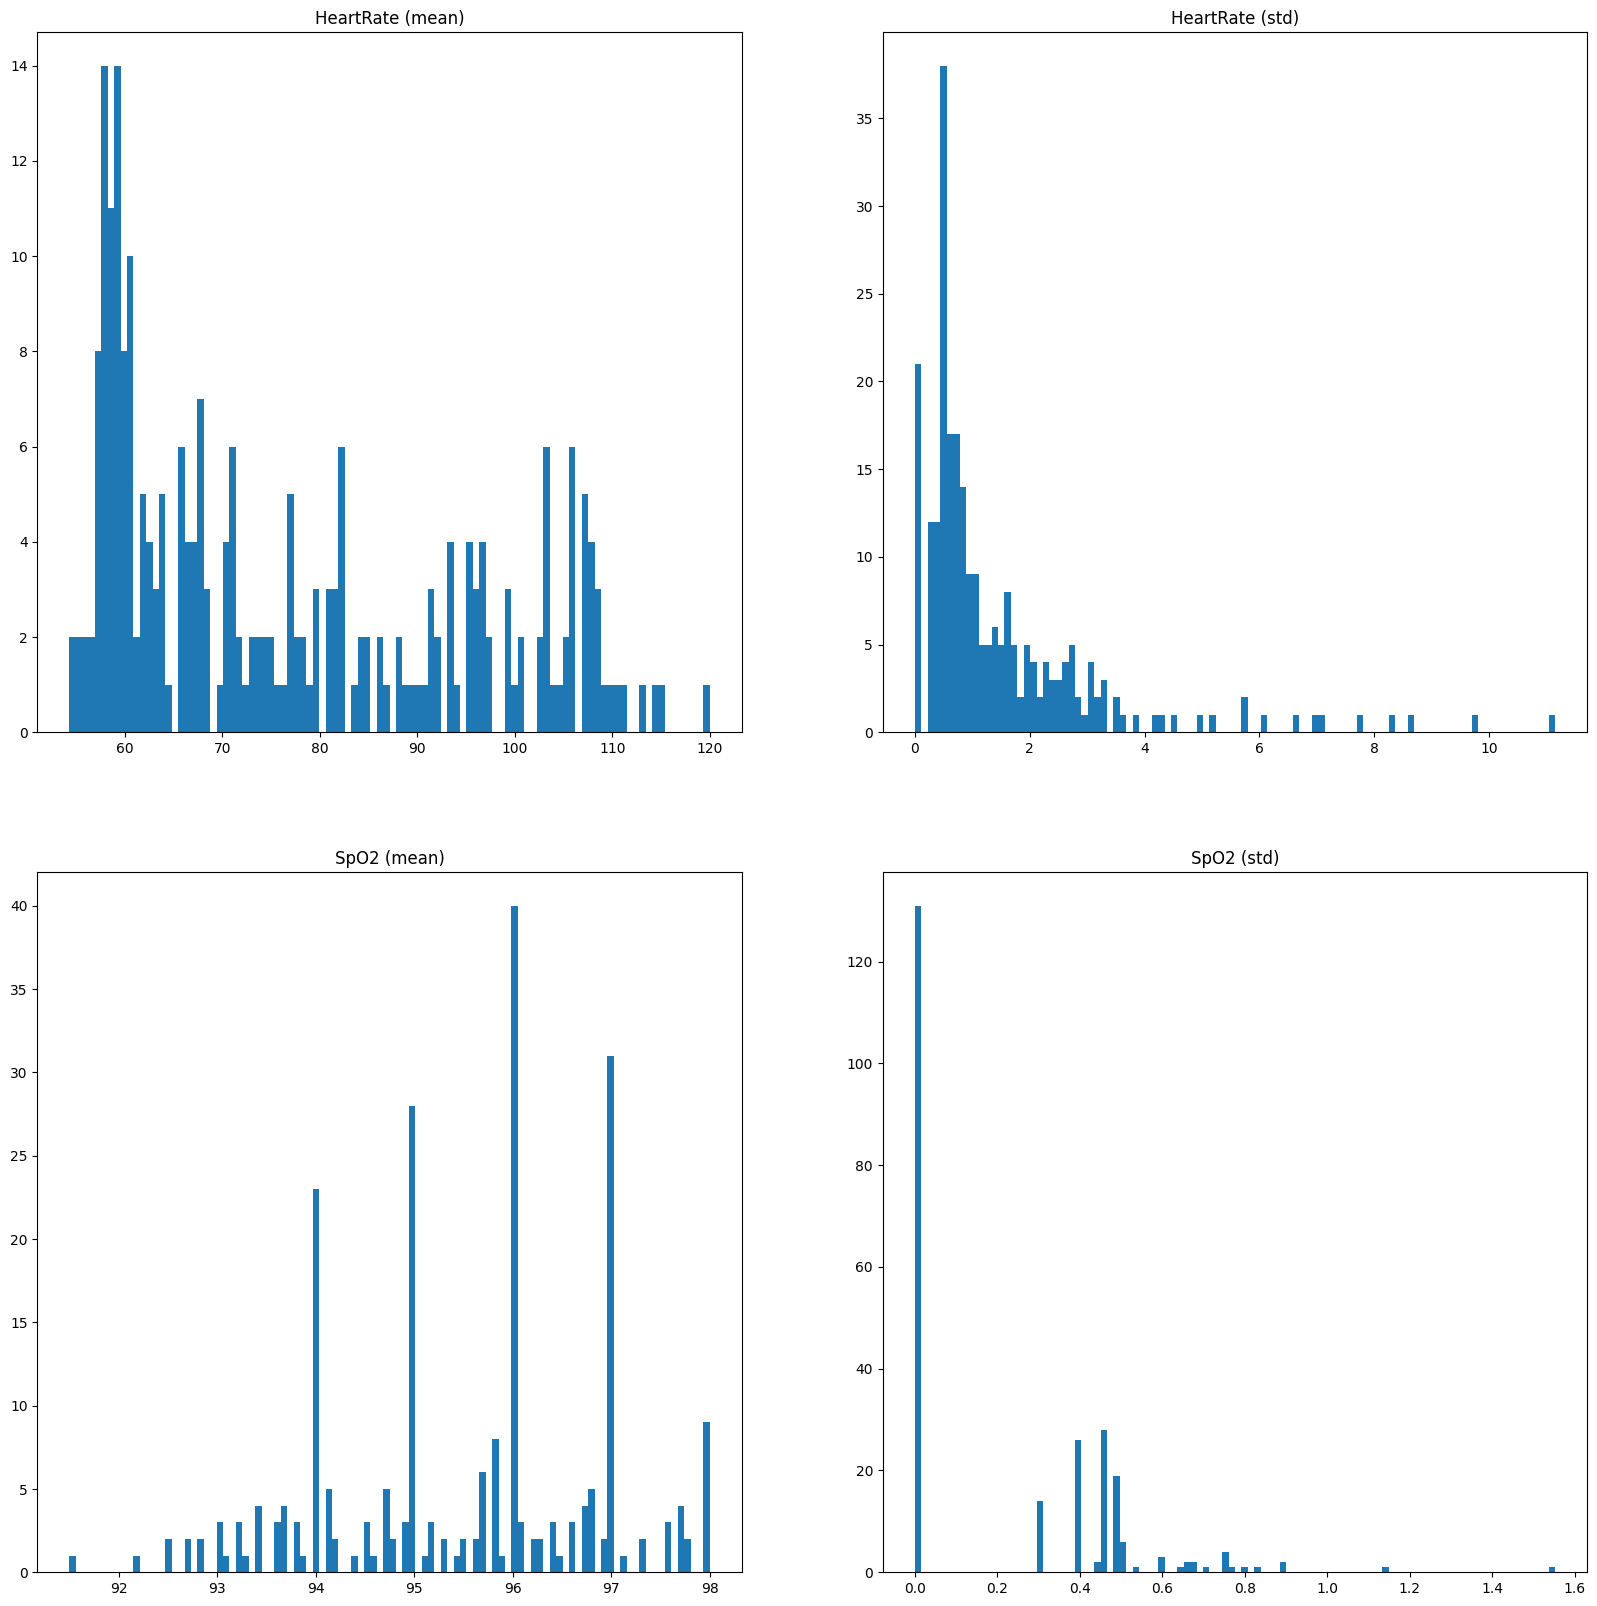

In [19]:
table_features_df = pd.DataFrame(data=eval_data_v0.numpy(), columns=dataprovider.view1_modalities)

fig, axs = plt.subplots(2,2,figsize=(20,20))
axs[0,0].hist(table_features_df['HeartRate_mean'].to_numpy(), bins=100);
axs[0,0].set_title('HeartRate (mean)');
axs[0,1].hist(table_features_df['HeartRate_std'].to_numpy(), bins=100);
axs[0,1].set_title('HeartRate (std)');

axs[1,0].hist(table_features_df['SpO2_mean'].to_numpy(), bins=100);
axs[1,0].set_title('SpO2 (mean)');
axs[1,1].hist(table_features_df['SpO2_std'].to_numpy(), bins=100);
axs[1,1].set_title('SpO2 (std)');

In [18]:
v1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(0.01<EDA_mean<=0.04),(1),0.184211,0.5,0.184211,1.0,2.0,0.092105,inf,0.612903
1,(0.07<AccZ_std<=0.64),(1),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
2,(31.90<Temp_mean<=33.56),(1),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
3,(27.10<Temp_mean<=30.80),(0),0.180162,0.5,0.180162,1.0,2.0,0.090081,inf,0.609877
4,(-0.00<AccY_std<=0.00),(0),0.192308,0.5,0.192308,1.0,2.0,0.096154,inf,0.619048
5,(-0.00<AccZ_std<=0.00),(0),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439


In [40]:
v1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(-0.00<AccZ_std<=0.00),(1),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439
1,(-0.00<EDA_std<=0.00),(1),0.168016,0.5,0.168016,1.0,2.0,0.084008,inf,0.600973
2,(27.10<Temp_mean<=30.80),(1),0.180162,0.5,0.180162,1.0,2.0,0.090081,inf,0.609877
3,(-0.00<AccX_std<=0.01),(1),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439
4,(-0.00<AccY_std<=0.00),(1),0.192308,0.5,0.192308,1.0,2.0,0.096154,inf,0.619048
5,(31.90<Temp_mean<=33.56),(0),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
6,(0.07<AccZ_std<=0.64),(0),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515


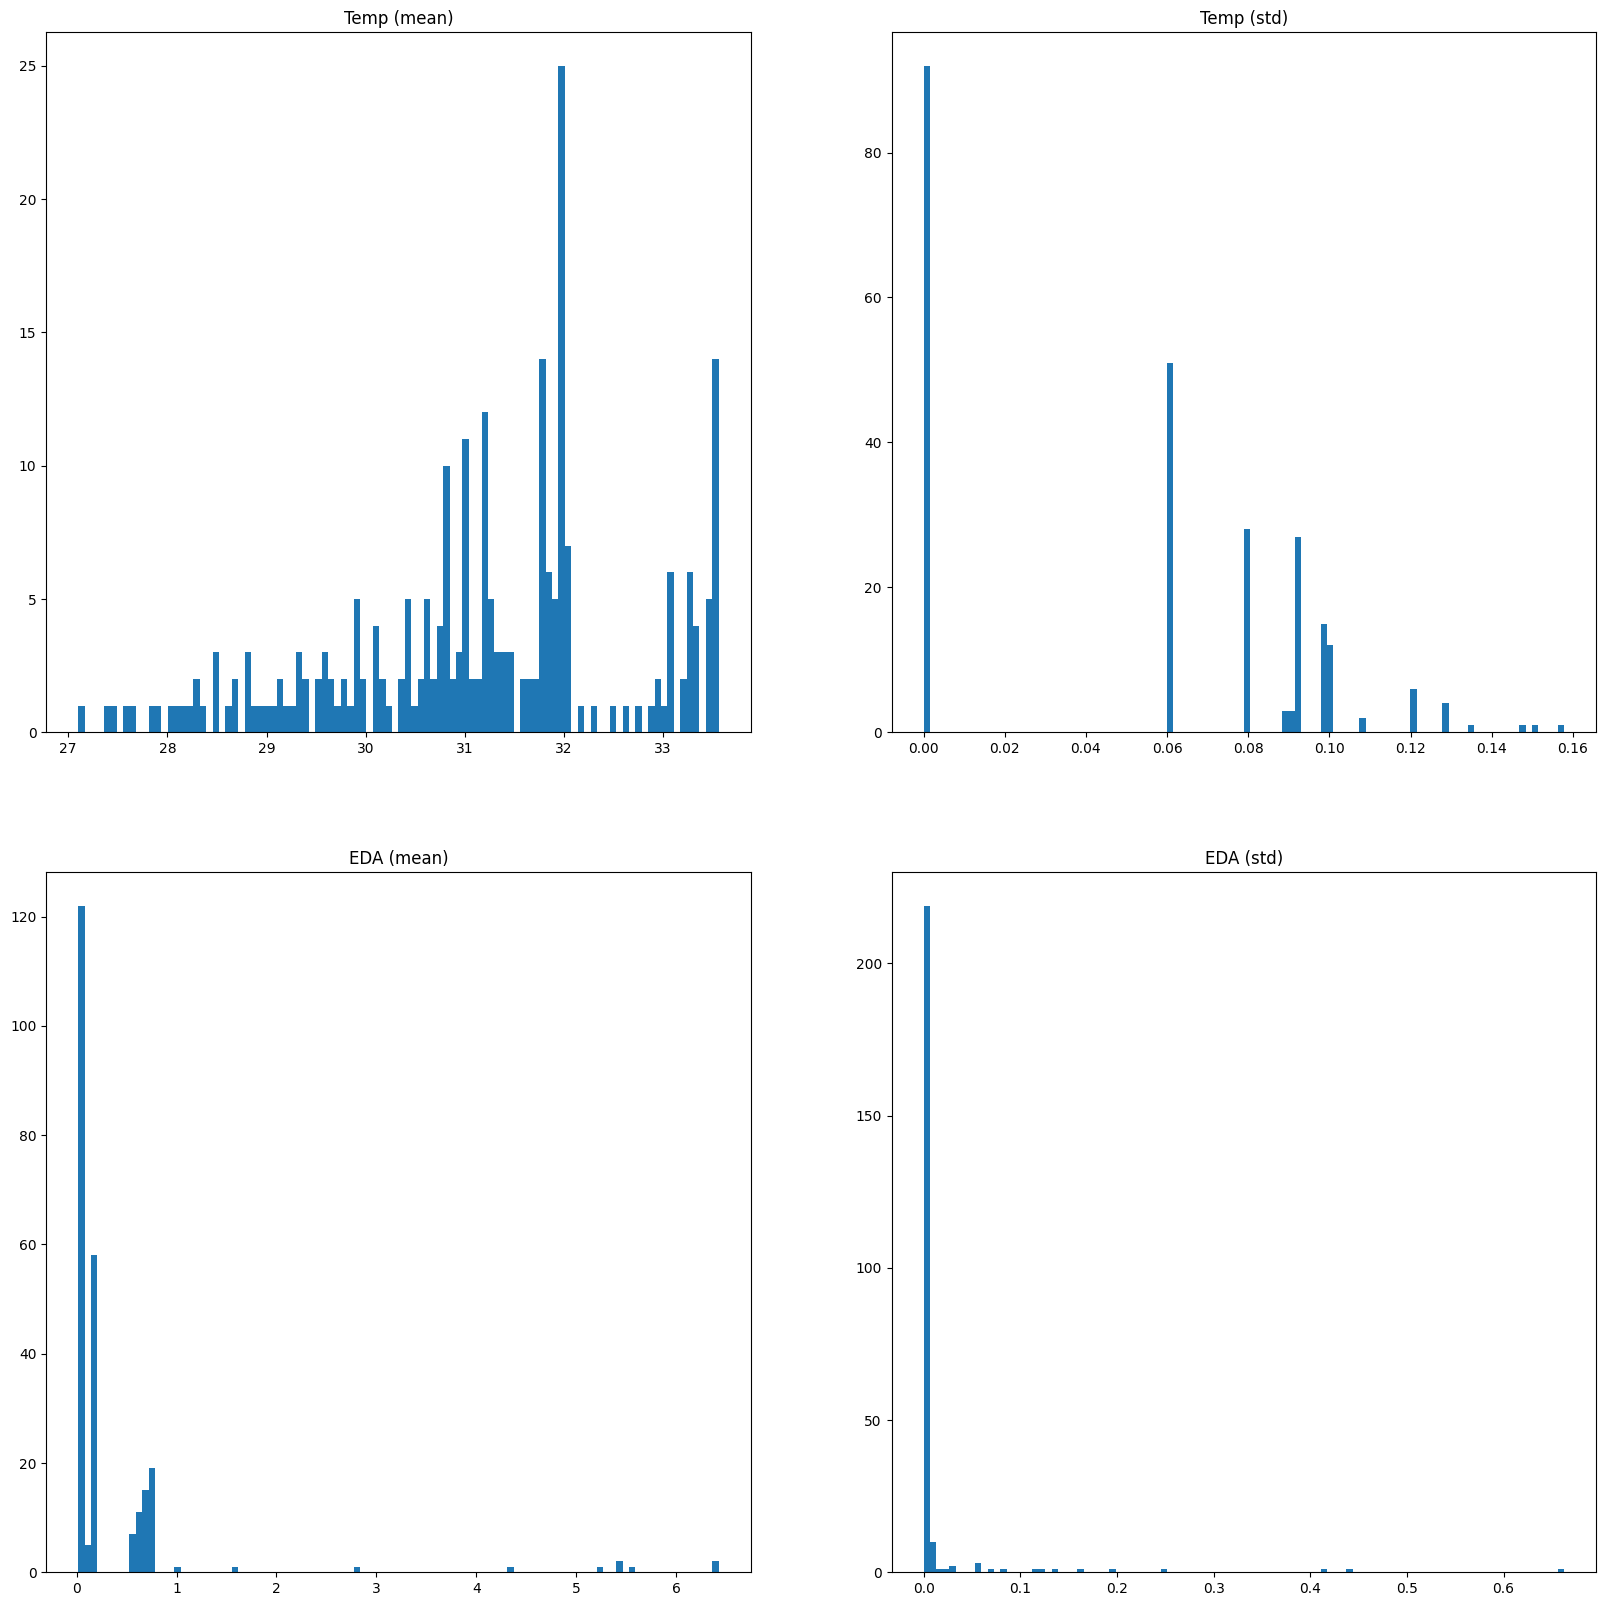

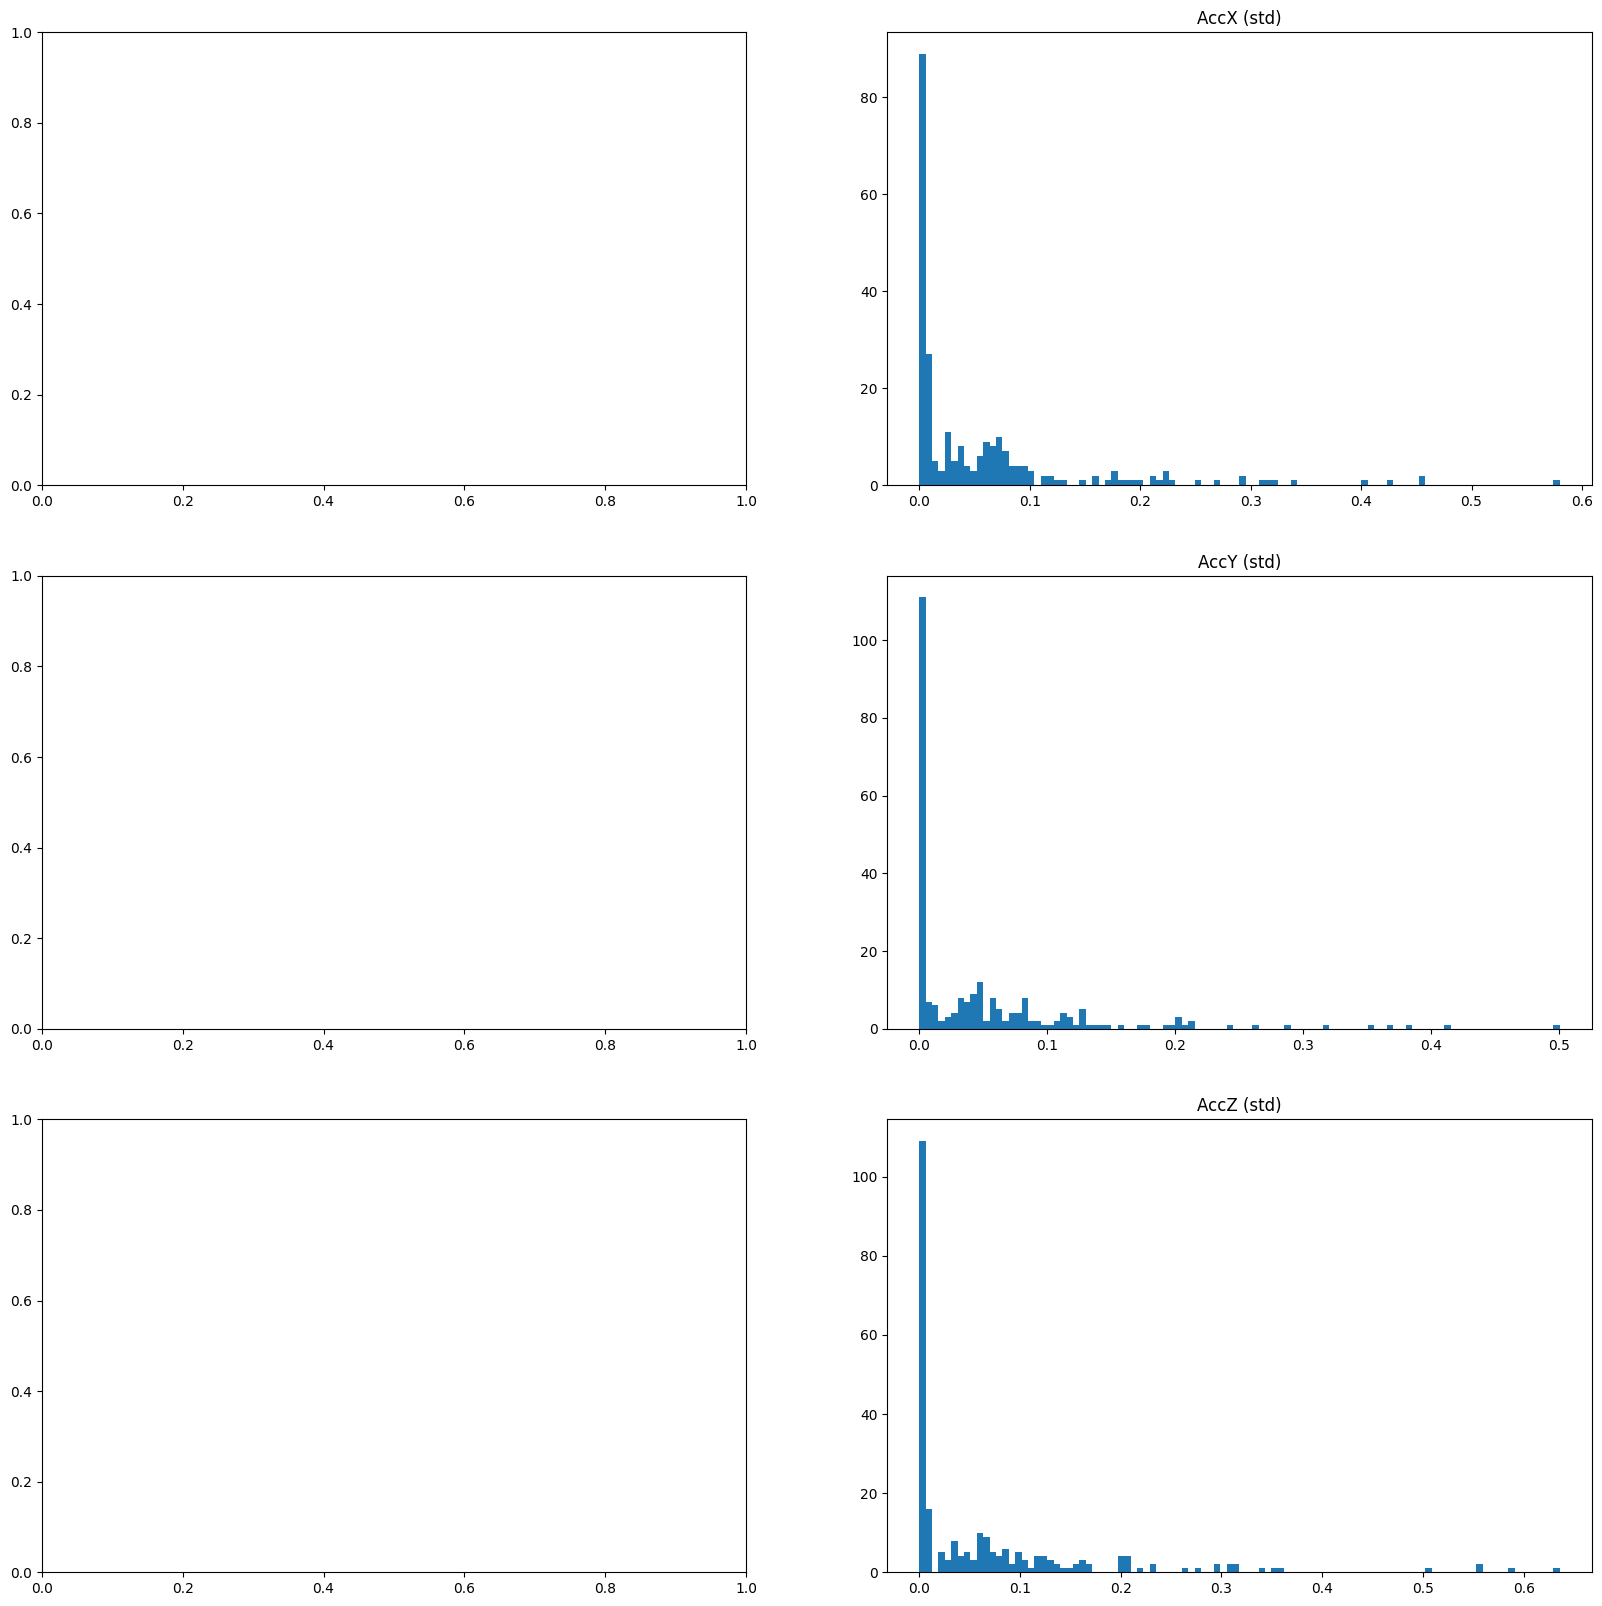

In [23]:
table_features_df = pd.DataFrame(data=eval_data_v1.numpy(), columns=dataprovider.view2_modalities)


fig, axs = plt.subplots(2,2,figsize=(20,20))
axs[0,0].hist(table_features_df['Temp_mean'].to_numpy(), bins=100);
axs[0,0].set_title('Temp (mean)');
axs[0,1].hist(table_features_df['Temp_std'].to_numpy(), bins=100);
axs[0,1].set_title('Temp (std)');

axs[1,0].hist(table_features_df['EDA_mean'].to_numpy(), bins=100);
axs[1,0].set_title('EDA (mean)');
axs[1,1].hist(table_features_df['EDA_std'].to_numpy(), bins=100);
axs[1,1].set_title('EDA (std)');

#fig, axs = plt.subplots(1,1,figsize=(10,10))

#axs.hist(table_features_df['Acc_std'].to_numpy(), bins=100)
#axs.set_title('Acc (std)');
fig, axs = plt.subplots(3,2,figsize=(20,20))
#axs[0,0].hist(table_features_df['AccX_mean'].to_numpy(), bins=100);
#axs[0,0].set_title('AccX (mean)');
axs[0,1].hist(table_features_df['AccX_std'].to_numpy(), bins=100);
axs[0,1].set_title('AccX (std)');

#axs[1,0].hist(table_features_df['AccY_mean'].to_numpy(), bins=100);
#axs[1,0].set_title('AccY (mean)');
axs[1,1].hist(table_features_df['AccY_std'].to_numpy(), bins=100);
axs[1,1].set_title('AccY (std)');

#axs[2,0].hist(table_features_df['AccZ_mean'].to_numpy(), bins=100);
#axs[2,0].set_title('AccZ (mean)');
axs[2,1].hist(table_features_df['AccZ_std'].to_numpy(), bins=100);
axs[2,1].set_title('AccZ (std)');


# Feature 2

In [19]:
pos_v0, pos_v1, neg_v0, neg_v1, v0, v1 = compare_views(feature_idx=1, bins=3, shap_thr_v0=0.01,shap_thr_v1=0.05)

In [20]:
v0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(0.40<SpO2_std<=1.55),(1),0.153846,0.5,0.153846,1.0,2.0,0.076923,inf,0.590909
1,(91.50<SpO2_mean<=95.00),(1),0.208502,0.5,0.208502,1.0,2.0,0.104251,inf,0.631714
2,(96.00<SpO2_mean<=98.00),(0),0.155870,0.5,0.155870,1.0,2.0,0.077935,inf,0.592326


In [21]:
v1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(0.01<EDA_mean<=0.04),(1),0.184211,0.5,0.184211,1.0,2.0,0.092105,inf,0.612903
1,(0.00<EDA_std<=0.00),(1),0.159919,0.5,0.159919,1.0,2.0,0.079960,inf,0.595181
2,(-0.00<EDA_std<=0.00),(1),0.174089,0.5,0.174089,1.0,2.0,0.087045,inf,0.605392
3,(31.90<Temp_mean<=33.56),(1),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
4,(-0.00<AccZ_std<=0.00),(1),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439
5,(-0.00<AccY_std<=0.00),(1),0.192308,0.5,0.192308,1.0,2.0,0.096154,inf,0.619048
6,(-0.00<AccX_std<=0.01),(1),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439
7,(0.07<AccZ_std<=0.64),(0),0.163968,0.5,0.163968,1.0,2.0,0.081984,inf,0.598063
8,(0.06<AccX_std<=0.58),(0),0.155870,0.5,0.155870,1.0,2.0,0.077935,inf,0.592326
9,(27.10<Temp_mean<=30.80),(0),0.180162,0.5,0.180162,1.0,2.0,0.090081,inf,0.609877


In [28]:
exp.save()

INFO:tensorflow:Assets written to: /upb/groups/sst/scratch/mkuschel/tf_logs/new_epi_workstation/_netwdim_512_shdim_5_l1_0E+0_l2_1E-3_radem_0E+0_topk_10/04/assets


INFO:tensorflow:Assets written to: /upb/groups/sst/scratch/mkuschel/tf_logs/new_epi_workstation/_netwdim_512_shdim_5_l1_0E+0_l2_1E-3_radem_0E+0_topk_10/04/assets


# Feature 3

In [29]:
pos_v0, pos_v1, neg_v0, neg_v1, v0, v1 = compare_views(feature_idx=2, bins=3, shap_thr_v0=0.01,shap_thr_v1=0.05)

In [30]:
v0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(96.00<SpO2_mean<=98.00),(1),0.155870,0.5,0.155870,1.000000,2.000000,0.077935,inf,0.592326
1,(-0.00<SpO2_std<=0.40),(1),0.340081,0.5,0.265182,0.779762,1.559524,0.095142,2.270270,0.543671
2,(62.30<HeartRate_mean<=82.20),(1),0.165992,0.5,0.159919,0.963415,1.926829,0.076923,13.666667,0.576748
3,(1.45<HeartRate_std<=11.15),(1),0.165992,0.5,0.165992,1.000000,2.000000,0.082996,inf,0.599515
4,(91.50<SpO2_mean<=95.00),(0),0.210526,0.5,0.210526,1.000000,2.000000,0.105263,inf,0.633333
5,(0.40<SpO2_std<=1.55),(0),0.153846,0.5,0.153846,1.000000,2.000000,0.076923,inf,0.590909
6,(-0.00<HeartRate_std<=0.54),(0),0.168016,0.5,0.168016,1.000000,2.000000,0.084008,inf,0.600973


In [31]:
v1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(-0.63<AccZ_mean<=-0.04),(1),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439
1,(31.90<Temp_mean<=33.56),(1),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
2,(-0.58<AccY_mean<=-0.08),(1),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
3,(0.01<EDA_mean<=0.04),(1),0.184211,0.5,0.184211,1.0,2.0,0.092105,inf,0.612903
4,(-0.00<AccY_std<=0.00),(1),0.192308,0.5,0.192308,1.0,2.0,0.096154,inf,0.619048
5,(-0.55<AccX_mean<=0.29),(1),0.168016,0.5,0.168016,1.0,2.0,0.084008,inf,0.600973
6,(-1.04<AccY_mean<=-0.87),(0),0.180162,0.5,0.180162,1.0,2.0,0.090081,inf,0.609877
7,(-0.00<AccX_std<=0.01),(0),0.170040,0.5,0.170040,1.0,2.0,0.085020,inf,0.602439
8,(0.66<AccX_mean<=1.00),(0),0.165992,0.5,0.165992,1.0,2.0,0.082996,inf,0.599515
9,(27.10<Temp_mean<=30.80),(0),0.180162,0.5,0.180162,1.0,2.0,0.090081,inf,0.609877
